In [1]:
#default_exp anime.dataloader

In [2]:
#export
import pandas as pd
from pathlib import Path
import json
from functools import partial
from PIL import Image
import numpy as np
from itertools import chain
from fast.torch_basics import *
from fast.layers import *
from fast.data.all import *
from fast.data.block import *
from fast.optimizer import *
from fast.learner import *
from fast.metrics import *
from fast.callback.all import *
from fast.vision.all import *
from anime.ugatit import *
from fast.callback.wandb import WandbCallback
from anime.kid import *
import wandb
#from fast.callback.tensorboard import TensorBoardCallback

In [3]:
# True = use GPU
defaults.use_cuda=True 
path=Path("/home/fast/.fastai/data/danbooru2018")
meta_path=path/'metadata/2018000000000016'
portraits=pd.read_pickle(path/'portraits')
selfie_path=Path('/home/fast/.fastai/data/Selfie-dataset')
self_txt= selfie_path/'selfie_dataset.txt'
self_txt.exists()
attrs='image_name popularity partial_faces is_female baby child teenager youth middle_age senior white black asian oval_face round_face heart_face smiling mouth_open frowning wearing_glasses wearing_sunglasses wearing_lipstick tongue_out duck_face black_hair blond_hair brown_hair red_hair curly_hair straight_hair braid_hair showing_cellphone using_earphone using_mirror braces wearing_hat harsh_lighting dim_lighting'.split()

## Tag comparison

In [4]:
def getSelfiePath(df,dir,i):
    dft=df.iloc[[i]]
    path=dir/((dft['image_name']).values[0]+'.jpg')
    return (dft.values,path)
def getImagePath(df,dir,i):
    dft=df.iloc[[i]]
    path=dir/'512px'/(dft['directory']+'/'+dft['file']).values[0]
    return (dft.tags.values[0],path)

In [5]:
class DSList():
    def __init__(self,name='selfie2anime'):
        self.name=name
    def __call__(self):
        if(self.name=='selfie2anime'):
            return self._selfie2anime()
        elif(self.name=='_danbooru'):
            return self._danbooru()
    def _danbooru(self):
        def txt_to_path(img,dir=dir,ext='.jpg'):
            return dir/(img+ext)
        selfies=pd.read_pickle(selfie_path/'selfies')
        selfie_imgs=L(list(selfies['image_name'].apply(partial(txt_to_path,dir=selfie_path/'images'))))
        f=partial(txt_to_path,dir=path/'512px',ext='')
        locs=portraits['directory']+'/'+portraits['file']
        anime_imgs=L(list(locs.apply(f)))
        return selfie_imgs,anime_imgs
    def _selfie2anime(self):
        selfie_imgs=L(Path("/home/fast/.fastai/data/selfie2anime/trainA").ls())
        anime_imgs=L(Path("/home/fast/.fastai/data/selfie2anime/trainB").ls())
        return selfie_imgs,anime_imgs
selfie_imgs,anime_imgs=DSList()()
len(anime_imgs),len(selfie_imgs)

(3400, 3400)

In [6]:
tfms = [PILImage.create]
ds_img_tfms = [ToTensor()]

In [7]:
class CycleImage(Tuple):
    def toTensor(self):
        img1,img2 = self
        return torch.cat([img1,img2], dim=2)
    def show(self, ctx=None, **kwargs): 
        return show_image(self.toTensor(),  ctx=ctx)

In [8]:
class CyclePair(Transform):
    def __init__(self,bItems):
        self.small = bItems #(aItems,bItems) if len(aItems)>len(bItems) else (bItems,aItems)
        self.assoc = self
        
    def encodes(self,i):
        "x: tuple of `i`th image and a random image from same or different class; y: True if same class"
        return CycleImage(i, random.choice(self.small)) #CycleImage(self.large[i], random.choice(self.small))

In [9]:
class ToTensorTuple(TupleTransform):
    "Convert item to appropriate tensor class"
    order = 15
@ToTensorTuple
def encodes(self, o:CycleImage): return TensorImage(image2byte(o))

In [10]:
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).resize((sz,sz))
    # Convert image to tenshttp://127.0.0.1:8888/notebooks/anime/Dataloading.ipynb#or for modeling
    x = array(x)
    #Shouldn't I be normalizing data?!??!?
    if x.ndim==3:
        return tensor(x).permute(2,0,1).float()/255.
    elif x.ndim==2:
        return tensor(x)[None].repeat(3,1,1).float()/255.
OpenAndResize = TupleTransform(resized_image)

In [11]:
OpenAndResize.encodes(CyclePair(anime_imgs).encodes(selfie_imgs[0]))

(PosixPath('/home/fast/.fastai/data/selfie2anime/trainA/female_10.jpg'),
 PosixPath('/home/fast/.fastai/data/selfie2anime/trainB/0511.jpg'))

In [12]:
tm=[CyclePair(anime_imgs), OpenAndResize, IntToFloatTensor(div=False)]#+[ToTensorTuple(),]

In [13]:
after_batch=[Cuda()]#Cuda(),#+aug_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1, max_lighting=0.2,
                   #max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None,
                   #size=None, mode='bilinear', pad_mode=PadMode.Reflection)
tfm=Pipeline(tm, as_item=False) #+after_batch

In [14]:
class NoopTensor(Transform):
    def encodes(self, x): return CycleImage(torch.Tensor([[[0]]]),torch.Tensor([[[0]]])) #needs to match output of network type

In [15]:
tfm2=Pipeline([NoopTensor()],as_item=False)

In [16]:
selfieL=0 #3400
selfieL=len(selfie_imgs) if selfieL<3 or selfieL>len(selfie_imgs) else selfieL
selfie_sample=selfie_imgs.shuffle()[0:selfieL]
val_size=100#20 if selfieL>24 else selfieL//2
val=selfie_sample[0:val_size]
tfmDs=DataSource(selfie_sample,[tfm,tfm2],splits=[[selfie not in val for selfie in selfie_sample],[selfie in val for selfie in selfie_sample]])

In [17]:
dl=TfmdDL(tfmDs,bs=1, shuffle=False, num_workers=8,after_batch=after_batch)

In [18]:
db=dl.databunch(bs=1,val_bs=1,after_batch=after_batch)
# DataBunch(dl) testing above

In [19]:
@typedispatch
def show_batch(x, y, samples, ctxs=None, max_n=9, **kwargs):
    if ctxs is None: ctxs = Inf.nones
    for i in range_of(samples[0]):
        [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs,range(max_n))]
    return ctxs

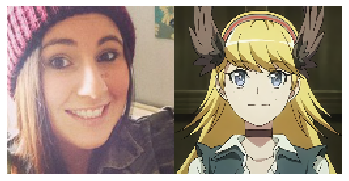

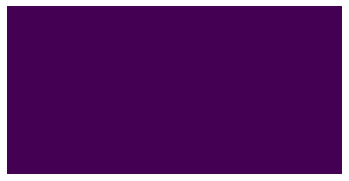

In [20]:
dt=dl._pre_show_batch(dl.one_batch(), max_n=9)
#import pdb; pdb.set_trace()
#show_batch(*dt, max_n=9)

show_batch(*dt, max_n=9)

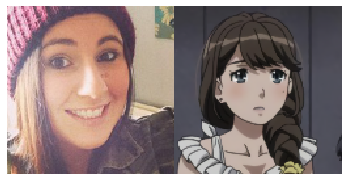

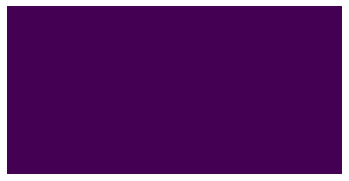

In [21]:
#import pdb; pdb.set_trace()
dl.show_batch()

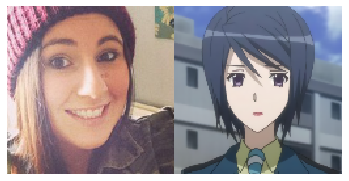

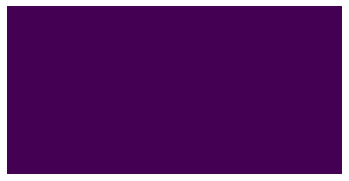

In [22]:
CycleImage(dl._pre_show_batch(dl.one_batch(), max_n=9)[0][0][0],dl._pre_show_batch(dl.one_batch(), max_n=9)[0][1][0]).show()
CycleImage(dl._pre_show_batch(dl.one_batch(), max_n=9)[1][0][0],dl._pre_show_batch(dl.one_batch(), max_n=9)[1][1][0]).show()

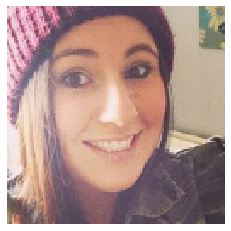

In [23]:
show_image(dl._pre_show_batch(dl.one_batch(), max_n=9)[0][0][0])

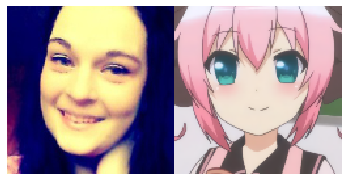

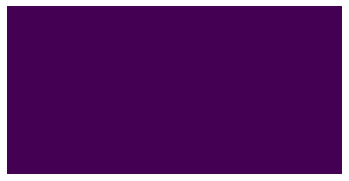

In [24]:
db.show_batch()

In [25]:
ugatit=UGATIT()
ugatit.build_model()

In [26]:
noop_loss = lambda x: torch.FloatTensor([0])

In [27]:
class GANOptimizer(object):
    def __init__(self, gen_optim,disc_optim,params,lr):
        gen_params,disc_params=params
        #might want to try lower lr for the generator
        self.gen_optim,self.disc_optim=gen_optim(gen_params,lr=lr),disc_optim(disc_params,lr=lr)
        self.optimizing_gen=True
    def __getattr__(self, item):
        opt= self.gen_optim if(self.optimizing_gen) else self.disc_optim
        return getattr(opt, item)
    def zero_grad(self):
        self.gen_optim.zero_grad()
        self.disc_optim.zero_grad()
    def state_dict(self):
        gs = self.gen_optim.state_dict()
        ds = self.disc_optim.state_dict()
        return {'hypers':{
                    'gen':gs['hypers'],
                    'disc':ds['hypers']},
                'state':{
                    'gen':gs['state'],
                    'disc':ds['state']}}
    def load_state_dict(self, sdict):
        self.gen_optim.load_state_dict({'hypers': sdict['param_groups']['gen'],'state':sdict['state']['gen']})
        self.disc_optim.load_state_dict({'param_groups': sdict['param_groups']['disc'],'state':sdict['state']['disc']})
        
#TODO unable to run one_batch twice without two after_batch calls
#TODO discriminator probably doesn't need gradients from generator, check cycle gan code/paper
class Switch(Callback):
    def begin_epoch(self):
        self.gan_losses=self.loss_func
        self.learn.disc_pass=False #TODO too many (not disc_pass), switch to gen_pass?!?
        self.model.optimizing_gen= not self.learn.disc_pass
        self.learn.loss_func=self.gan_losses[self.learn.disc_pass]
        self.opt.zero_grad()
    def after_step(self):
        self.learn.disc_pass=not self.learn.disc_pass
        self.model.optimizing_gen= not self.learn.disc_pass
        self.opt.optimizing_gen= not self.learn.disc_pass
        self.opt.zero_grad()
        self.learn.loss_func=self.gan_losses[self.learn.disc_pass]
        if(self.learn.disc_pass):
            self.one_batch(self.iter,L(self.xb+self.yb))
    def after_epoch(self):
        self.loss_func=self.gan_losses
            
class RhoClipper(Callback):
    def after_batch(self):
        self.model.models['GA2B'].apply(ugatit.Rho_clipper)
        self.model.models['GB2A'].apply(ugatit.Rho_clipper)
class PrintLoss(Callback):
    def after_loss(self):
        if(self.iter%100==0):    
            print('batch: #'+str(self.iter)+'/'+str(self.n_iter)+'/'+str(self.epoch))
            if(self.learn.disc_pass):
                print('loss Disc: '+str(self.loss.item()))
            else:
                print('loss Gen: '+str(self.loss.item()))
class LinearDecreaseLR(Callback):
    def __init__(self,start_epoch=0,end_epoch=None):
        store_attr(self,"start_epoch,end_epoch")
    def begin_fit(self):
        self.max_lr=self.lr
    def end_fit(self):
        self.lr=self.max_lr
    def begin_batch(self):
        end_epoch = self.end_epoch if(self.end_epoch) else self.n_epoch
        current_iter=(self.epoch+self.start_epoch)*self.n_iter+self.iter
        run_length=end_epoch*self.n_iter
        half_run=run_length // 2
        if current_iter > half_run:
            self.lr = (run_length-current_iter)*self.max_lr/(run_length-half_run)
            self.opt.set_hyper('lr',self.lr)
class SameXbYb(Callback):
    def after_pred(self):
        self.learn.yb=self.learn.xb

In [28]:
#@typedispatch
#def tensorboard_log(x:CycleImage, y: CycleImage, samples, outs, writer, step):
#    fig,axs = get_grid(len(samples), add_vert=1, return_fig=True, double=True)
#    for i in range(2):
#        axs[::2] = [b.show(ctx=c) for b,c in zip(samples.itemgot(i),axs[::2])]
#    for x in [samples,outs]:
#        axs[1::2] = [b.show(ctx=c) for b,c in zip(x.itemgot(0),axs[1::2])]
#    writer.add_figure('Sample Results', fig, step)

In [29]:
@typedispatch
def wandb_process(x:CycleImage, y:CycleImage, samples, outs):
    "Process `sample` and `out` depending on the type of `x/y`"
    res = []
    for s,o in zip(samples, outs):
        img = TensorImage(s[0].toTensor()[0])
        #db.valid_dl.decode(s)
        res.append(wandb.Image(img, caption='Input data', grouping=3))
        for t, capt in ((o[0], "Prediction"), (s[1], "Ground Truth")):
            # Resize plot to image resolution (from https://stackoverflow.com/a/13714915)
            my_dpi = 100
            fig = plt.figure(frameon=False, dpi=my_dpi)
            h, w = img.shape[:2]
            fig.set_size_inches(w / my_dpi, h / my_dpi)
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            # Superimpose label or prediction to input image
            ax = img.show(ctx=ax)
            ax = t.show(ctx=ax)
            res.append(wandb.Image(fig, caption=capt))
            plt.close(fig)
    return res

In [30]:
#logs=Path('/home/fast/.fastai/'+'tensorboard')

In [31]:
wandb.init()

W&B Run: https://app.wandb.ai/marii/uncategorized/runs/mrlvg7fk

In [32]:
def multi_model_params(models):
    ps=[]
    for m in models:
        ps+=[p for p in m.parameters() if p.requires_grad]
    return ps
def GAN_splitter(model):
    gen_params=itertools.chain(model.models['GA2B'].parameters(),model.models['GB2A'].parameters())
    disc_params=itertools.chain(model.models['DA'].parameters(),model.models['DB'].parameters(),model.models['LA'].parameters(),model.models['LB'].parameters())
    return (gen_params,disc_params)

#targs_func = lambda b: np.resize(b[0][1].numpy(),[1,3,299,299])
#kid=KIDCallback(Tensor(array(list(map(targs_func,db.valid_dl)))))
#metrics=kid.kid
learner=Learner(db,UgatitModel(ugatit.models),UGATITLoss(ugatit.models).losses,partial(GANOptimizer,Adam,Adam),0.0001,splitter=GAN_splitter)
learner.add_cbs(L([Switch(),RhoClipper(),PrintLoss(),LinearDecreaseLR(),SameXbYb(),WandbCallback(valid_dl=learner.dbunch.valid_dl)]))

In [33]:
#learner=learner.load((Path('/home/fast/.fastai/m1')),device='cpu')

Try using just the generator, discriminator, and pre-trained GAN output. Loss function would be adverserial loss + MSE-ish loss with pre-trained GANs output. LR would have to decrease overtime and/or wight between adv loss and MSE loss would need to be more adverserial. 

In [34]:
learner.to_fp16??

In [35]:
learner.to_fp16()
class MixedPrecisionTuple(MixedPrecision):
    def after_pred(self): 
        #fp16=lambda t:tuple(x.half() for x in t)
        #self.learn.pred = tuple(map(fp16,self.learn.pred))
        print('noop')
    def after_loss(self):
        if self.training: self.learn.loss *= self.loss_scale
mixedFilter=lambda x:str(type(x))=="<class 'fast.callback.fp16.MixedPrecision'>"
learner.remove_cbs(learner.cbs.filter(mixedFilter))
learner.add_cb(MixedPrecisionTuple())

In [36]:
#import pdb; pdb.set_trace()
#300 total
learner.fit(300) #60

noop
noop


TypeError: mul(): argument 'other' (position 1) must be Tensor, not tuple

In [ ]:
learner.one_batch??

In [ ]:
MixedPrecision??

In [ ]:
learner.loss

In [ ]:
learner.recorder._train_mets[0].beta


In [ ]:
#learner.save(path/'Nov_26th')

In [ ]:
inception = torch.hub.load('pytorch/vision:v0.4.2', 'inception_v3', pretrained=True)
inception.eval()

In [ ]:
inception=Inception_v3()
state = torch.hub.load('pytorch/vision:v0.4.2', 'inception_v3', pretrained=True).state_dict()

### Potential BUG!!!!! nn.DataStructure registers modules again, might be double updating weights!!!

In [ ]:
inception.load_state_dict(state)

In [ ]:
if dl is None: dl = learner.dbunch.dls[ds_idx]
b = dl.one_batch()
_,_,preds = learner.get_preds(dl=dl,ds_idx=1, with_decoded=True)

In [ ]:
b=learner.dbunch.valid_dl.one_batch()
_,_,preds = learner.get_preds(dl=[b], with_decoded=True)

In [ ]:
#not actually useful
learner.recorder._valid_mets[0].total=0
learner.recorder._valid_mets[0].count=0

In [ ]:
learner.training=False
b = learner.dbunch.valid_dl.one_batch()
learner.one_batch(0, b)
preds = getattr(learner.loss_func, 'activation', noop)(learner.pred)
out = getattr(learner.loss_func, 'decodes', noop)(preds)
#import pdb; pdb.set_trace()
#think i can take loss.decode -> Tensor.decode -> CycleImage.decode
x,y,its,outs = learner.dbunch.valid_dl.show_results(b, out,show=False, max_n=9)
#tensorboard_log(x, y, its, outs, self.writer, self.train_iter)

In [ ]:
vdl=learner.dbunch.valid_dl
its=vdl.after_batch(vdl.do_batch([vdl.do_item(0)]))
print(mapped(type,its))
#torch.Tensor(vdl.after_batch(vdl.do_batch([vdl.do_item(0)]))[1])
print(CycleImage(its[0][0].cpu()))

In [ ]:
self.show_batch(b_out, max_n=max_n, show=False)

In [ ]:
samples=[]
for i,(xb,yb) in enumerate(iter(db.valid_dl)):
    xbA,xbB=xb
    fake_Bb=learner.model.models['GA2B'](xbA)[0].detach()
    ins=xbA[0]
    show_image(xbA[0])
    samples+=[fake_Bb[0]]
    if(i>10): break

In [ ]:
#json.load(Path('/home/fast/.fastai/m1.pth'))

In [ ]:
for i in range(len(samples)):
    show_image(samples[i])

In [ ]:
#hide
#from fast.notebook.export import notebook2script
#notebook2script(all_fs=True)

In [ ]:
# TIP !!! use_partial_data data source use partial data (keep pct) 
# MixedPrecision

In [ ]:
def num_open_resize(fn:Path, sz:Int=299):
    x = Image.open(fn).resize((sz,sz))
    # Convert image to tenshttp://127.0.0.1:8888/notebooks/anime/Dataloading.ipynb#or for modeling
    x = array(x, dtype=np.float32)
    #Shouldn't I be normalizing data?!??!?
    if x.ndim==3:
        return x/255.
    elif x.ndim==2:
        return x.repeat(1,1,3)/255.

In [ ]:
anime_imgs[0]

In [ ]:
np.save(str(path/'selfie_mmd_test_full'),array([num_open_resize(selfie_imgs[i]) for i in range(len(selfie_imgs))]))

In [ ]:
np.save(str(path/'anime_mmd_test_full'),array([num_open_resize(anime_imgs[i]) for i in range(len(anime_imgs))]))

#learner=Learner(db,ugatit.models,[noop_loss,noop_loss],[Adam,Adam],0.0001,splitter=multi_model_params)
#class UGATITLearner(Learner):
#    "Group together a `model`, some `dbunch` and a `loss_func` to handle training"
#    def __init__(self, dbunch, models, loss_funcs=None, opt_funcs=[SGD,SGD], lr=None, splitter=trainable_params, cbs=None,
#                 cb_funcs=None, metrics=None, path=None, model_dir='models', wd_bn_bias=False, train_bn=True):
#        store_attr(self, "dbunch,splitter,model_dir,wd_bn_bias,train_bn")
#        self.model_GA2B,self.model_GB2A,self.model_DA,self.model_DB,self.model_LA,self.model_LB=models
#        self.generators=nn.ModuleList([self.model_GA2B,self.model_GB2A])
#        self.discriminators=nn.ModuleList([self.model_DA,self.model_DB,self.model_LA,self.model_LB])
#        self.model=nn.ModuleList([self.generators,self.discriminators])
#        self.models=self.model
#        self.opt_funcG,self.opt_funcD=opt_funcs
#        self.lr = defaults.lr if lr is None else lr
        #TODO: infer loss_func from data
#        self.loss_funcs = L([CrossEntropyLossFlat()]) if loss_funcs is None else loss_funcs
#        self.path = path if path is not None else getattr(dbunch, 'path', Path('.'))
#        self.metrics = [m if isinstance(m, Metric) else AvgMetric(m) for m in L(metrics)]
#        self.training,self.logger,self.opts = False,print,None
#        self.cbs = L([])
#        self.add_cbs(cbf() for cbf in L(defaults.callbacks[0])) #TODO Took out tracking due ot error
#        self.add_cbs(cbs)
#        self.add_cbs(cbf() for cbf in L(cb_funcs))
#        self.ugatit_loss=UGATITLoss(models)
#    
#    def create_opt(self,opt_func,models):
#        "Create an optimizer with `lr`"
#        opt = opt_func(self.splitter(models), lr=self.lr)
#        if not self.wd_bn_bias:
#            for p in bn_bias_params(models):
                opt.state[p] = {**opt.state.get(p, {}), 'do_wd': False}
        if self.train_bn:
            for p in bn_bias_params(models, with_bias=False):
                opt.state[p] = {**opt.state.get(p, {}), 'force_train': True}
        return opt
    
    def create_opts(self):
        #generator
        optG=self.create_opt(self.opt_funcG,self.generators)
        #discriminator
        optD=self.create_opt(self.opt_funcD,self.discriminators)
        return (optG,optD)

    # models? which models get which inputs?
    def one_batch(self, i, b):
        self.iter = i
        try:
            self._split(b)
            self('begin_batch')
            #self.pred = self.model_GA2B(self.xb[0][0]);             self('after_pred')
            l=self.ugatit_loss.generator_loss(self.xb[0])
            self.loss=l.item();         self('after_loss') #should use loss_func
            if not self.training: return
            l.backward();                           self('after_backward')
            
            self.opts[0].step();                                self('after_step')
            self.opts[0].zero_grad()
            
            l = self.ugatit_loss.discriminator_loss(self.xb[0]); #self('after_loss2')
            l.backward();                           #self('after_backward2')
            
            self.opts[1].step();                                #self('after_step2')
            self.opts[1].zero_grad()
            
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

In [ ]:
learner